# Take-home challenge: Free Pizza! - Lorent Caravaku

There is a dataset where each row corresponds to a request of a Reddit user, that has triggered a free pizza action (or not). Given all the information provided, we will train a model that will predict if a certain request is likely to receive a free pizza or not.

We are going to use the dataset data.json provided.
We are going to use a (2/3;1/3) ratio to split the dataset, so we can test our model.

The assumptions that we can make: 
The selection of user that will be offered a Pizza is based only on the text content and not on others information such as the date, the users votes, etc.

First we need to import all libraries.

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn import metrics
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk import pos_tag
from string import punctuation

We declare some variables/constants that we will need later.

In [2]:
DATASET_FILE = 'data.json'
STOPWORDS = 'stopwords.json'

lmt = WordNetLemmatizer()
nb = MultinomialNB()
lr = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')

We import the dataset.

In [3]:
# Opening Dataset (data.json)
with open(DATASET_FILE) as fin: 
    data = json.load(fin)

We import some additional english stopwords that we will remove from the dataset. Stopwords are non-content words that primarily has only grammatical function.

In [4]:
# Opening stopwords.json file
with open(STOPWORDS) as fin: 
    stopwords01 = json.load(fin)

We create a combined stoplist with three different sources of stopwords.

In [5]:
# Creating Stopwords set
stopwords01_ = set(stopwords01['en'])
stopwords02_ = set(stopwords.words('english'))
stopwords03_ = set(punctuation)
stoplist_combined = set.union(stopwords01_, stopwords02_, stopwords03_)

"penn2morphy" converts penn treebank tags to WordNet.

In [6]:
def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    # Input: str - peen tag
    # Output: str - wordNet
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 

"lemmatize" maps the different forms of the same word to the same root word.

In [7]:
def lemmatize(text): 
    """ Finding the root words """
    # Input: str - text
    # Output: (lowercase) str - text.
    return [lmt.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(word_tokenize(text))]

"prepocess" will remove stopwords and lemmatize

In [8]:
def preprocess(text):
    """ Removing stopwords and digits """
    # Input: str - document/sentence
    # Output: list(str) - list of lemmas
    return [word for word in lemmatize(text) 
            if word not in stoplist_combined
            and not word.isdigit()]

Creating Dataframe from json formated data

In [9]:
# Creating Dataframe from json formated data
df = pd.io.json.json_normalize(data)

Keeping only relevant information (based on the assumptions made)

In [10]:
# Keeping only relevant information (based on the assumptions made)
df_train = df[['request_id', 'request_title', 
               'request_text_edit_aware', 
               'requester_received_pizza']]

Spliting data into two subsets : training dataset and test dataset

In [11]:
# Spliting data into two subsets : training dataset and test dataset
train, test = train_test_split(df_train, test_size=0.3)

Vectorizing Datasets

In [12]:
# Vectorizing Datasets
count_vect = CountVectorizer(analyzer=preprocess)
train_set = count_vect.fit_transform(train['request_text_edit_aware'])
train_tags = train['requester_received_pizza']
test_set = count_vect.transform(test['request_text_edit_aware'])
test_tags = test['requester_received_pizza']

Training NB and LR model

In [13]:
# Training NB model
nb_clf = nb.fit(train_set, train_tags) 
lr_clf = lr.fit(train_set, train_tags)

Testing the trained model

In [14]:
# Testing the trained model
predictions_test_nb = nb_clf.predict(test_set)
predictions_test_lr = lr_clf.predict(test_set)

In [15]:
# Printing accuracy
print('\n-- Accuracy --')
print('MultinomialNB = {}'.format(
        accuracy_score(predictions_test_nb, test_tags) * 100)
     )
print('LogisticRegression = {}'.format(
        accuracy_score(predictions_test_lr, test_tags) * 100)
     )


-- Accuracy --
MultinomialNB = 72.27722772277228
LogisticRegression = 67.9042904290429


Cross Validation

In [16]:
print('\n-- Cross Validation Accuracy --')
scores_nb = cross_val_score(nb, train_set, train_tags, cv=3)
print('MultinomialNB = ', scores_nb)
scores_lr = cross_val_score(lr, train_set, train_tags, cv=3)
print('LogisticRegression = ', scores_lr)


-- Cross Validation Accuracy --
MultinomialNB =  [ 0.73170732  0.73064687  0.73142251]
LogisticRegression =  [ 0.71367975  0.72004242  0.72717622]


Plot MultinomialNB model ROC

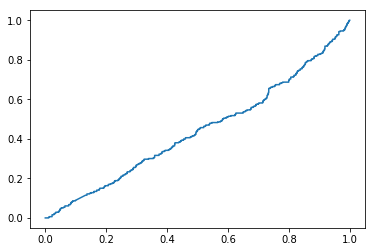

In [17]:
# Ploting ROC: Receiver Operating Characteristic
fpr_nb, tpr_nb, thresh_nb = metrics.roc_curve(test_tags, nb_clf.predict_proba(test_set)[:, 1])
plt.plot(fpr_nb, tpr_nb)
plt.show()

Plot LogisticRegression model ROC

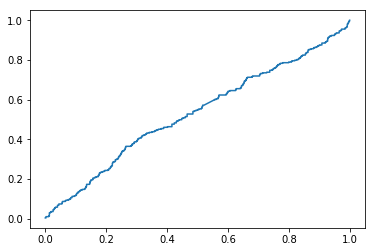

In [18]:
# Ploting ROC: Receiver Operating Characteristic
fpr_lr, tpr_lr, thresh_lr = metrics.roc_curve(test_tags, lr_clf.predict_proba(test_set)[:, 1])
plt.plot(fpr_lr, tpr_lr)
plt.show()